In [1]:
pwd

'/Users/jamahusseinmohamud/Desktop/research/DM research/large_scale_correlations/large_scale_task_correlation/notebooks'

In [2]:
%cd ..

/Users/jamahusseinmohamud/Desktop/research/DM research/large_scale_correlations/large_scale_task_correlation


In [3]:
import torch
import math
import csv
import torchvision
from torchvision import transforms
from PIL import Image
from src.models.architectures import ResNet18
import multiprocessing
from sklearn.cluster import KMeans
from collections import defaultdict
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
from graph_tool.all import *
from graph_tool.draw import graph_draw
from sklearn.cluster import SpectralCoclustering
import graph_tool.all as gt
import matplotlib.pyplot as plt
from src.cocoapi.PythonAPI.pycocotools.coco import COCO

In [4]:
seed = 3971
torch.random.seed()
np.random.seed(seed=seed)

In [5]:
ann_file = "./data/coco_datasets/annotations/instances_train2017.json"
coco = COCO(ann_file)

# Get list of category_ids, here [2] for bicycle
category_ids = coco.getCatIds(["bicycle"])

# Get list of image_ids which contain bicycles
image_ids = coco.getImgIds(catIds=[category_ids[0]])
print("category_ids: ", category_ids)
print("image_ids: ", image_ids[0:5])

loading annotations into memory...
Done (t=8.90s)
creating index...
index created!
category_ids:  [2]
image_ids:  [196610, 344067, 155652, 417797, 294918]


In [6]:
image_ids = np.array(coco.getImgIds())
print(len(image_ids))
image_ids

118287


array([391895, 522418, 184613, ..., 516168, 547503, 475546])

image_path: ./data/coco_datasets/images/train2017/000000184613.jpg


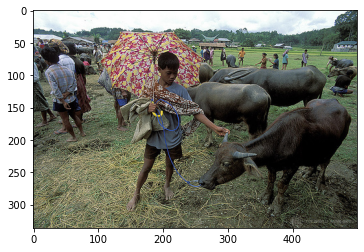

In [7]:
image_name = coco.loadImgs(ids=[184613])[0]['file_name']
image_path = f'./data/coco_datasets/images/train2017/{image_name}'
print(f"image_path: {image_path}")
image = Image.open(image_path)
plt.imshow(image)
plt.show()

In [9]:
cat_ids = coco.getCatIds()
print('number_classes: ', len(cat_ids), 'first category id: ', cat_ids[0], 'catefory_name: ', coco.loadCats(ids=[cat_ids[0]])[0]['name'])

number_classes:  80 first category id:  1 catefory_name:  person


In [10]:
multilabel_matrix = np.zeros((len(image_ids), len(cat_ids)))

for i, imgIds in enumerate(image_ids):
    # imgIds = 397133
    for j, catId in enumerate(cat_ids):
        annotation_ids = coco.getAnnIds(imgIds=imgIds, catIds=[catId])
        # print('catId: ', catId, '| label: ', coco.loadCats(ids=[catId])[0]['name'] , '| total: ', len(annotation_ids))
        if len(annotation_ids) > 0:
            multilabel_matrix[i][j] = 1

In [13]:
label_names = []
for catId in cat_ids:
    label_name = coco.loadCats(ids=[catId])[0]['name']
    label_names.append(label_name)

np.array(label_names)

array(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
       'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
       'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
       'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
       'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
       'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
       'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
       'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
       'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
       'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
       'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
       'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
       'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
       'scissors', 'teddy bear', 'hair drier', 'toothbrush'], dtype='<U14')

In [14]:
correlation_matrix = np.corrcoef(multilabel_matrix, rowvar = False)
corr_df = pd.DataFrame(correlation_matrix)
corr_df.columns = label_names
correlation_matrix.shape

(80, 80)

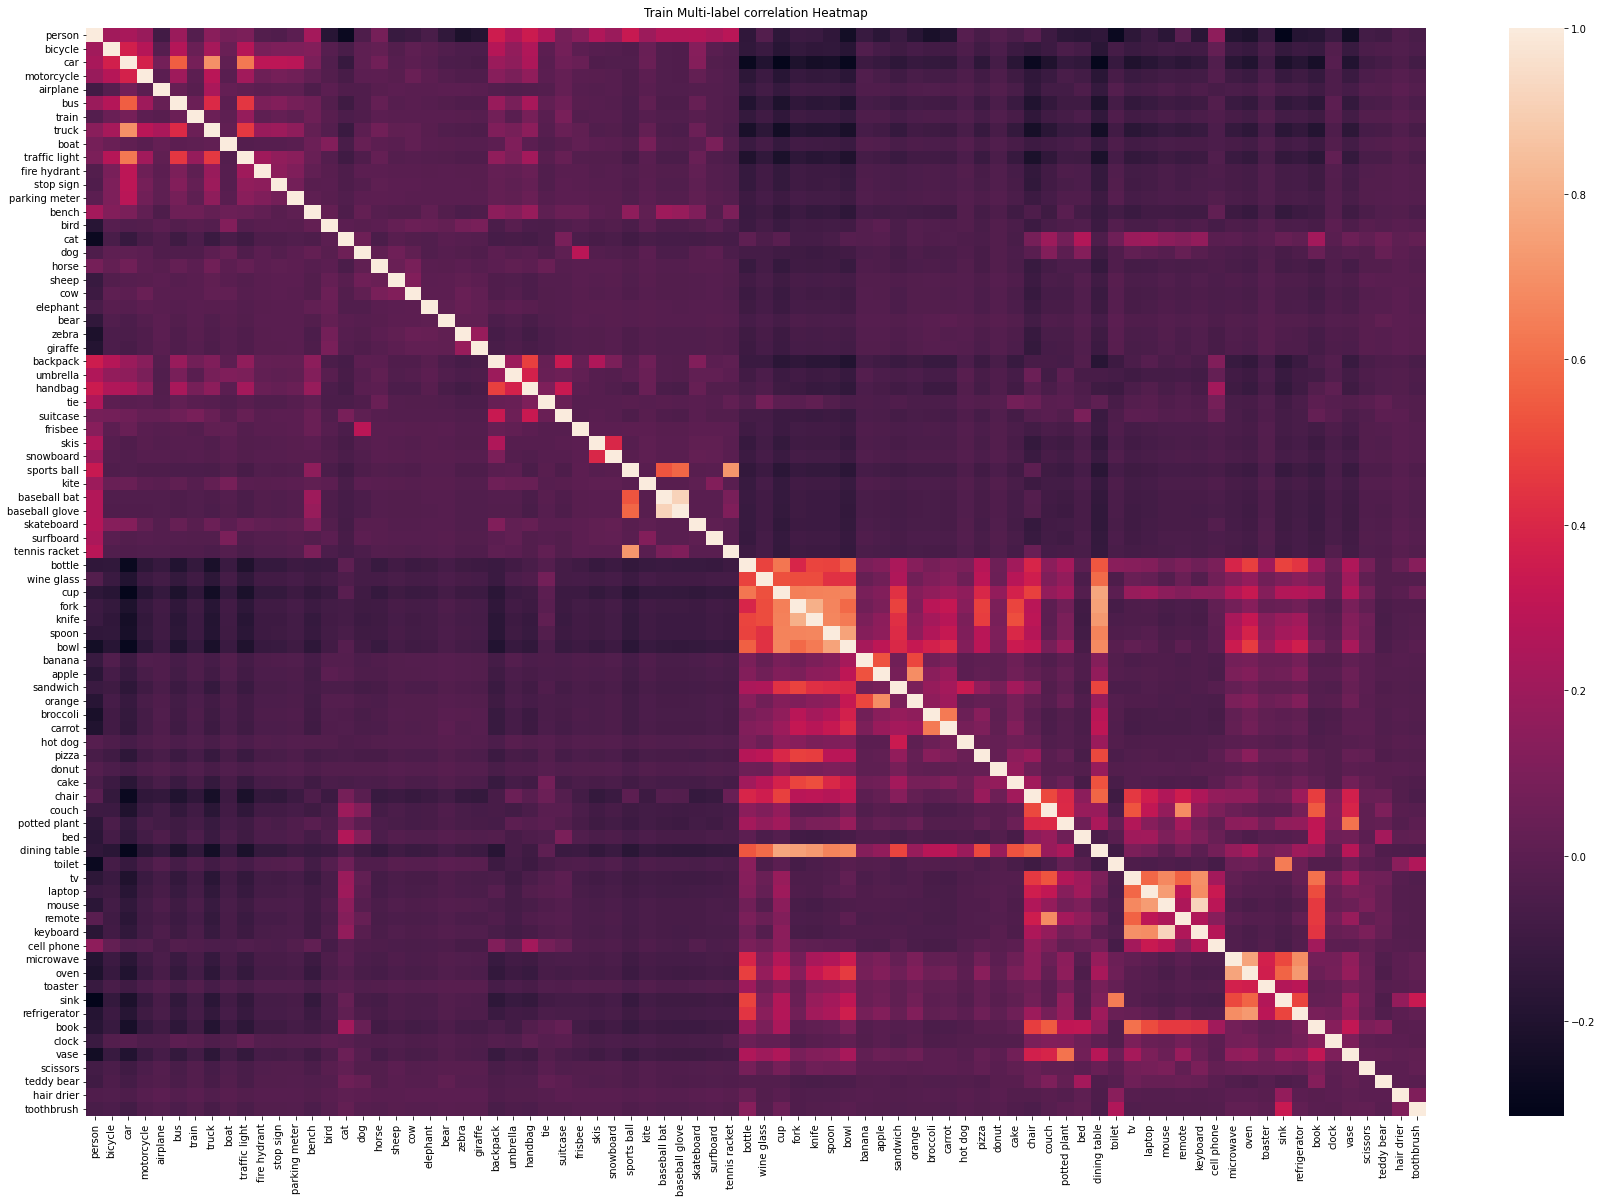

In [15]:
# Increase the size of the heatmap.
plt.figure(figsize=(30, 20))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr_df.corr(), annot=False)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Train Multi-label correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

In [16]:
# Create an empty undirected Graph
g = Graph(directed=False)

# Add vertices to the graph
vlist = g.add_vertex(correlation_matrix.shape[0])

# Create an edge property map for the weights
weight = g.new_edge_property("double")

# Loop over the correlation matrix and add edges with weights
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        e = g.add_edge(g.vertex(i), g.vertex(j))
        weight[e] = correlation_matrix[i, j]  # set the weight of the edge

# Save the edge property map to the graph
g.ep['weight'] = weight


In [17]:


# Normalize the weights to the range [0, 1] for visualization
weight.a = (weight.a - weight.a.min()) / (weight.a.max() - weight.a.min())

graph_draw(g, edge_color=weight, output="cm_graph_coco.png")


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2c66c5580, at 0x2cbac5d60>

### Spectral clustering visualization

In [18]:


def update_graph(g):
    # Create a networkx graph from the adjacency matrix
    # Get the edge weights as a property map
    edge_weights = g.ep["weight"]
    # Convert graph-tool graph to adjacency matrix, considering the weights
    adj_matrix = gt.adjacency(g, weight=edge_weights).toarray()
    # np.fill_diagonal(adj_matrix, 1)

    G = nx.from_numpy_array(adj_matrix)
    return G


In [19]:

n_clusters = 4

# Initialize the model
model = SpectralCoclustering(n_clusters=n_clusters, random_state=0)

# Fit the model and predict cluster labels
model.fit(correlation_matrix)

# Get row and column labels
row_labels = model.row_labels_
col_labels = model.column_labels_
assert (row_labels == col_labels).all()

In [20]:
col_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 3, 3, 2, 3, 0, 2, 3, 3, 3, 3,
       3, 2, 0, 0, 2, 0, 0, 3, 2, 2, 2, 2, 2, 2], dtype=int32)

In [21]:
def create_cluster_layout(G, labels):
    # Create a layout for each cluster
    pos = defaultdict(dict)
    offsets = {0: np.array([2, 2]),
               1: np.array([-2, 2]),
               2: np.array([-2, 5]),
               3: np.array([2, 5])}
    for label in set(labels):
        subgraph_nodes = [node for node in G.nodes if labels[node] == label]
        subgraph = G.subgraph(subgraph_nodes)
        subgraph_pos = nx.spring_layout(subgraph)
        pos[label] = subgraph_pos

    # Combine the layouts -- with a distinct offset to separate clusters
    combined_pos = dict()
    for label in pos:
        offset = offsets[label]
        for node in pos[label]:
            combined_pos[node] = pos[label][node] + offset

    return combined_pos

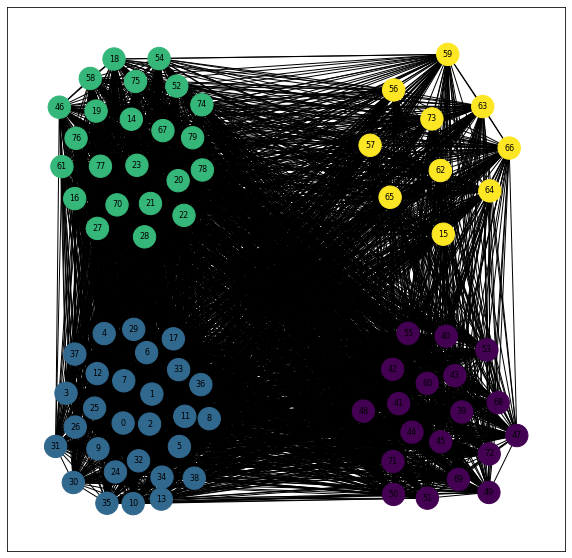

In [23]:

# G = update_graph(g)
# # Create a layout for the graph
# pos = create_cluster_layout(G, labels=row_labels)
# Create a new figure
plt.figure(figsize=(10,10))
# Draw the graph using the layout
nx.draw_networkx(G, pos, node_color=col_labels, with_labels=True, node_size=500, font_size=8)
plt.savefig("coco_spectral_clustering_viz.pdf", bbox_inches="tight")
plt.show()

In [24]:

def get_cluster_map(labels, label_names):
    cluster_label_to_name_map_spec = defaultdict(list)

    for i, cl_label in enumerate(labels):
        cluster_label_to_name_map_spec[str(cl_label)].append(label_names[i])
    return cluster_label_to_name_map_spec

get_cluster_map(labels=row_labels, label_names=label_names)

defaultdict(list,
            {'1': ['person',
              'bicycle',
              'car',
              'motorcycle',
              'airplane',
              'bus',
              'train',
              'truck',
              'boat',
              'traffic light',
              'fire hydrant',
              'stop sign',
              'parking meter',
              'bench',
              'horse',
              'backpack',
              'umbrella',
              'handbag',
              'frisbee',
              'skis',
              'snowboard',
              'sports ball',
              'kite',
              'baseball bat',
              'baseball glove',
              'skateboard',
              'surfboard',
              'tennis racket'],
             '2': ['bird',
              'dog',
              'sheep',
              'cow',
              'elephant',
              'bear',
              'zebra',
              'giraffe',
              'tie',
              'suitcase',
             

### Kmeans clustering Visualization

In [25]:
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(correlation_matrix)
kmeans.labels_


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 1, 3, 1, 1, 2, 1, 2, 1, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 0, 2, 0, 2, 2, 2, 2], dtype=int32)

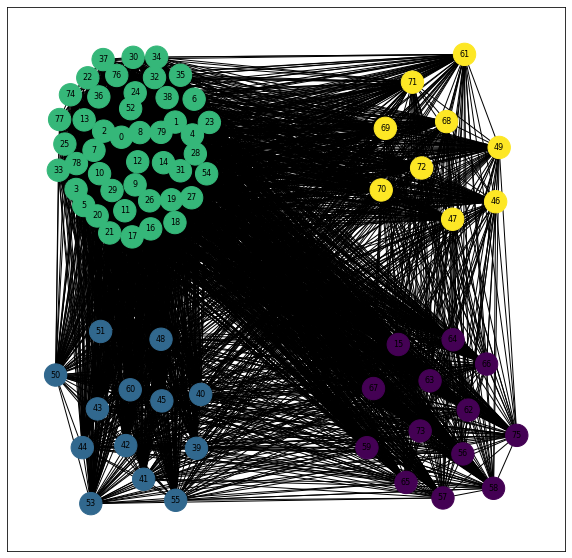

In [27]:
# Create a layout for the graph
pos = create_cluster_layout(G, labels=kmeans.labels_)
# Create a new figure
plt.figure(figsize=(10,10))
# Draw the graph using the layout
nx.draw_networkx(G, pos, node_color=kmeans.labels_, with_labels=True, node_size=500, font_size=8)
plt.savefig("coco_kmeans_clustering_viz.pdf", bbox_inches="tight")
plt.show()

In [28]:
get_cluster_map(labels=kmeans.labels_, label_names=label_names)

defaultdict(list,
            {'2': ['person',
              'bicycle',
              'car',
              'motorcycle',
              'airplane',
              'bus',
              'train',
              'truck',
              'boat',
              'traffic light',
              'fire hydrant',
              'stop sign',
              'parking meter',
              'bench',
              'bird',
              'dog',
              'horse',
              'sheep',
              'cow',
              'elephant',
              'bear',
              'zebra',
              'giraffe',
              'backpack',
              'umbrella',
              'handbag',
              'tie',
              'suitcase',
              'frisbee',
              'skis',
              'snowboard',
              'sports ball',
              'kite',
              'baseball bat',
              'baseball glove',
              'skateboard',
              'surfboard',
              'tennis racket',
              'hot 

### Stockastic Block Model Visualization